# Variational Autoencoder

In [16]:
from vae import *
import sys
sys.path.append('../autodata')
import autodata
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MIMIC

In [17]:
# Load MIMIC dataset
x_train = autodata.read_csv('data/mimic_train_sdv.csv')
x_test = autodata.read_csv('data/mimic_test_sdv.csv')
original_dim = x_train.shape[1]

### a. Visualization

In [18]:
x_train.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0.736841,0.367033,0.178041,0.323594,0.178995,0.685247,0.695830,0.534141,0.007102,0.379733,...,0.566946,0.466166,0.454668,0.508533,0.043820,0.873301,0.439185,0.644301,0.927768,0.340453
1,0.325086,0.344490,0.104803,0.655811,0.783455,0.294163,0.398976,0.406052,0.018570,0.588893,...,0.998080,0.328330,0.248050,0.518272,0.475675,0.437482,0.300124,0.962873,0.200489,0.471393
2,0.365095,0.308756,0.431394,0.867922,0.765800,0.665502,0.799933,0.489344,0.006504,0.401370,...,0.560525,0.360634,0.359545,0.663067,0.062456,0.692662,0.137554,0.629658,0.914016,0.602066
3,0.076284,0.615019,0.186723,0.455209,0.347381,0.288593,0.731176,0.778186,0.010623,0.487919,...,0.513111,0.139621,0.480334,0.286370,0.414262,0.492274,0.865511,0.368510,0.817126,0.514404
4,0.180657,0.602065,0.864738,0.804294,0.297092,0.227642,0.029551,0.576505,0.012278,0.480707,...,0.451776,0.197078,0.419377,0.699087,0.332916,0.565916,0.208199,0.519025,0.823585,0.243542


TODO: class coloration


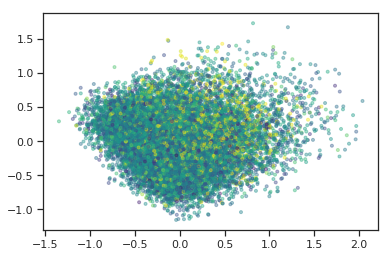

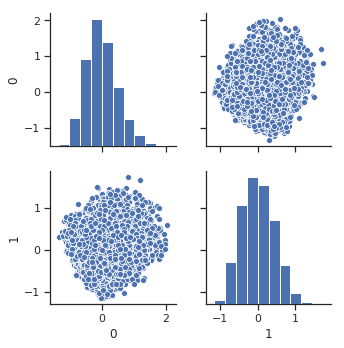

TODO: class coloration


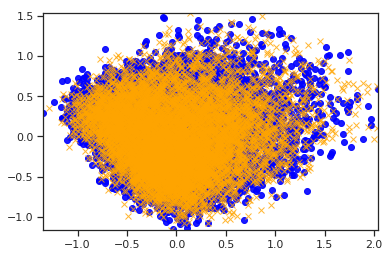

In [32]:
x_train.set_class('DIED')
c_tr = np.array(x_train.get_data('y').T).ravel()

x_test.set_class('DIED')
c_te = np.array(x_test.get_data('y').T).ravel()

pca = x_train.pca(n_components=2).plot(c=c_tr)

pca_tr = x_train.pca(n_components=2)[:8000]
pca_te = x_test.pca(n_components=2)[:8000]
autodata.plot(pca_tr, pca_te)

In [20]:
#x_train.distance(x_test)

### b. Training

Train on 13463 samples, validate on 13463 samples
Epoch 1/20
13463/13463 [==============================] - 1s 88us/step - loss: 230.1090 - val_loss: 228.6870
Epoch 2/20
13463/13463 [==============================] - 1s 66us/step - loss: 228.5241 - val_loss: 228.5039
Epoch 3/20
13463/13463 [==============================] - 1s 66us/step - loss: 228.4334 - val_loss: 228.4563
Epoch 4/20
13463/13463 [==============================] - 1s 65us/step - loss: 228.4021 - val_loss: 228.4248
Epoch 5/20
13463/13463 [==============================] - 1s 65us/step - loss: 228.3890 - val_loss: 228.4094
Epoch 6/20
13463/13463 [==============================] - 1s 69us/step - loss: 228.3799 - val_loss: 228.3942
Epoch 7/20
13463/13463 [==============================] - 1s 68us/step - loss: 228.3735 - val_loss: 228.3779
Epoch 8/20
13463/13463 [==============================] - 1s 67us/step - loss: 228.3668 - val_loss: 228.3719
Epoch 9/20
13463/13463 [==============================] - 1s 68us/step - loss:

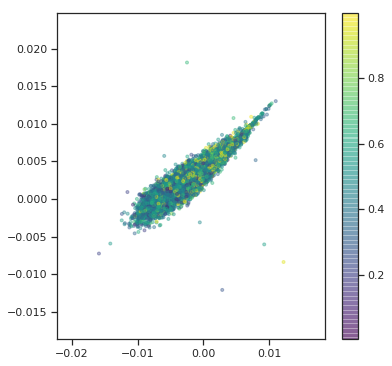

In [21]:
batch_size=128
epochs=20

model = VAE(original_dim, intermediate_dim=256, latent_dim=4)
vae, encoder, decoder = model.get_vae(), model.get_encoder(), model.get_decoder()

columns = x_train.columns
x_train_np, x_test_np = x_train.as_matrix(), x_test.as_matrix()

vae.fit(x_train_np,
        x_train_np,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_np, x_test_np))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test_np, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=c_te,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

### c. Benchmark

In [36]:
# Generate samples
n = x_test.shape[0]
x_decoded_np = model.sample(n, loc=0, scale=30)

x_decoded, x_test = autodata.AutoData(x_decoded_np, columns=columns), autodata.AutoData(x_test_np, columns=columns)

In [37]:
#x_decoded.distance(x_test)

TODO: class coloration


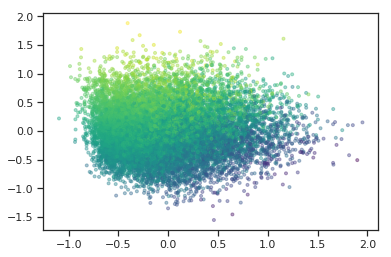

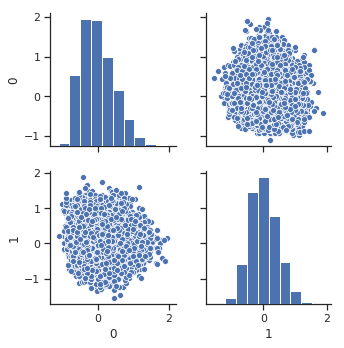

TODO: class coloration


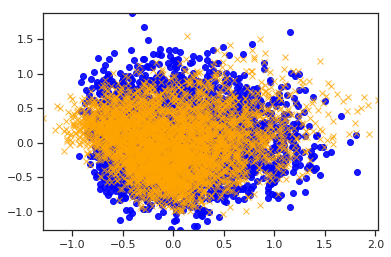

In [38]:
x_decoded.set_class('DIED')
c_dec = np.array(x_decoded.get_data('y').T).ravel()
pca = x_decoded.pca(n_components=2).plot(c=c_dec)

pca_dec = x_decoded.pca(n_components=2)[:4000]
pca_te = x_test.pca(n_components=2)[:4000]
autodata.plot(pca_dec, pca_te)

# MNIST

Source: http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/

In [10]:
# Load MNIST dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
original_dim = 28*28
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 86us/step - loss: 189.2484 - val_loss: 171.4402
Epoch 2/20
60000/60000 [==============================] - 5s 81us/step - loss: 169.3582 - val_loss: 167.4492
Epoch 3/20
60000/60000 [==============================] - 5s 81us/step - loss: 166.0061 - val_loss: 165.3658
Epoch 4/20
60000/60000 [==============================] - 5s 85us/step - loss: 163.7375 - val_loss: 163.2520
Epoch 5/20
60000/60000 [==============================] - 5s 83us/step - loss: 161.8858 - val_loss: 161.1542
Epoch 6/20
60000/60000 [==============================] - 5s 83us/step - loss: 160.3580 - val_loss: 160.1363
Epoch 7/20
60000/60000 [==============================] - 5s 84us/step - loss: 159.1582 - val_loss: 158.9453
Epoch 8/20
60000/60000 [==============================] - 5s 86us/step - loss: 158.2557 - val_loss: 158.2313
Epoch 9/20
60000/60000 [==============================] - 5s 80us/step - loss:

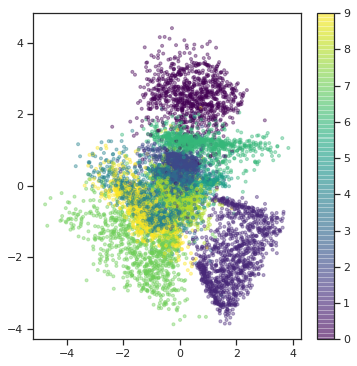

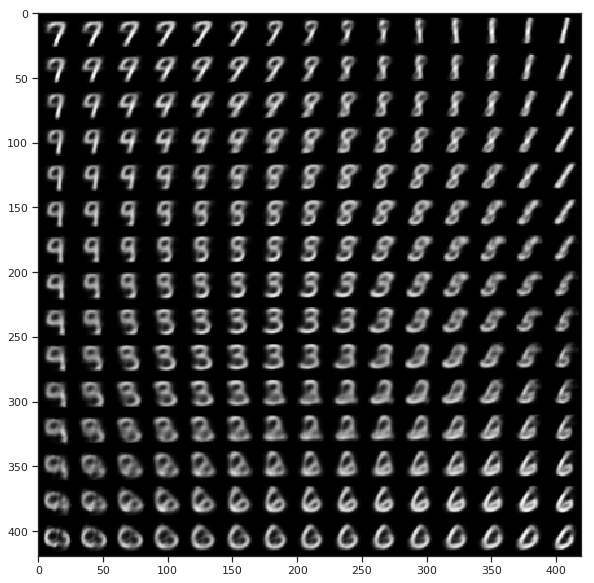

In [11]:
batch_size=100
epochs=20

model = VAE(original_dim, intermediate_dim=256, latent_dim=2)
vae, encoder, decoder = model.get_vae(), model.get_encoder(), model.get_decoder()

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()